In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import seaborn as sns

np.random.seed(42)

#### Define the 4 Gaussian Distributions

In [11]:
mean1 = np.array([-3, 3])
cov1 = np.array([[1.0, 0.3], 
                 [0.3, 1.0]])

mean2 = np.array([3, 3])
cov2 = np.array([[1.2, -0.2], 
                 [-0.2, 0.8]])

mean3 = np.array([0, -3])
cov3 = np.array([[1.5, 0.0], 
                 [0.0, 1.0]])

mean4 = np.array([0, 0])
cov4 = np.array([[2.0, 0.5], 
                 [0.5, 2.0]])

means = [mean1, mean2, mean3, mean4]
covs = [cov1, cov2, cov3, cov4]
class_priors = np.array([0.25, 0.25, 0.25, 0.25])

for i in range(4):
    print(f"\nClass {i+1}:")
    print(f"  Mean: {means[i]}")
    print(f"  Covariance Matrix:\n{covs[i]}")
print(f"\nClass Priors: {class_priors}")


Class 1:
  Mean: [-3  3]
  Covariance Matrix:
[[1.  0.3]
 [0.3 1. ]]

Class 2:
  Mean: [3 3]
  Covariance Matrix:
[[ 1.2 -0.2]
 [-0.2  0.8]]

Class 3:
  Mean: [ 0 -3]
  Covariance Matrix:
[[1.5 0. ]
 [0.  1. ]]

Class 4:
  Mean: [0 0]
  Covariance Matrix:
[[2.  0.5]
 [0.5 2. ]]

Class Priors: [0.25 0.25 0.25 0.25]


#### Generate 10,000 Samples

In [12]:
def generate_samples(n_samples, means, covs, priors):
    samples = []
    labels = []
    
    for _ in range(n_samples):
        label = np.random.choice([0, 1, 2, 3], p=priors)
        sample = np.random.multivariate_normal(means[label], covs[label])
        samples.append(sample)
        labels.append(label)
    
    return np.array(samples), np.array(labels)

n_samples = 10000
X, true_labels = generate_samples(n_samples, means, covs, class_priors)

print(f"Total samples: {n_samples}")
for i in range(4):
    count = np.sum(true_labels == i)
    print(f"Class {i+1}: {count} samples ({count/n_samples*100:.2f}%)")

Total samples: 10000
Class 1: 2483 samples (24.83%)
Class 2: 2508 samples (25.08%)
Class 3: 2523 samples (25.23%)
Class 4: 2486 samples (24.86%)


#### Part A - Implement MAP Classifier

In [13]:
def compute_class_posteriors(x, means, covs, priors):
    likelihoods = np.array([
        multivariate_normal.pdf(x, mean=means[j], cov=covs[j])
        for j in range(4)
    ])
    
    posteriors = likelihoods * priors
    # Normalize
    posteriors = posteriors / np.sum(posteriors)
    
    return posteriors

def map_classify(X, means, covs, priors):
    predictions = []
    
    for x in X:
        posteriors = compute_class_posteriors(x, means, covs, priors)
        prediction = np.argmax(posteriors)
        predictions.append(prediction)
    
    return np.array(predictions)

print("MAP classifier implemented successfully!")

MAP classifier implemented successfully!


#### Apply MAP Classifier and Compute Confusion Matrix

In [14]:
map_predictions = map_classify(X, means, covs, class_priors)

# Confusion matrix 
confusion_matrix = np.zeros((4, 4))
for j in range(4):
    mask = (true_labels == j)
    total_j = np.sum(mask)
    
    if total_j > 0:
        for i in range(4):
            confusion_matrix[i, j] = np.sum(map_predictions[mask] == i) / total_j

print("\nConfusion Matrix P(D=i|L=j) (rows=decision, columns=true label):")
print("     L=1    L=2    L=3    L=4")
for i in range(4):
    print(f"D={i+1}: ", end="")
    for j in range(4):
        print(f"{confusion_matrix[i,j]:.4f} ", end="")
    print()

# Compute accuracy
accuracy = np.sum(map_predictions == true_labels) / n_samples
print(f"\nOverall Accuracy: {accuracy:.4f}")
print(f"Error Rate: {1-accuracy:.4f}")


Confusion Matrix P(D=i|L=j) (rows=decision, columns=true label):
     L=1    L=2    L=3    L=4
D=1: 0.9863 0.0012 0.0000 0.0197 
D=2: 0.0020 0.9705 0.0000 0.0571 
D=3: 0.0000 0.0000 0.9239 0.1259 
D=4: 0.0117 0.0283 0.0761 0.7973 

Overall Accuracy: 0.9196
Error Rate: 0.0804


#### Visualization

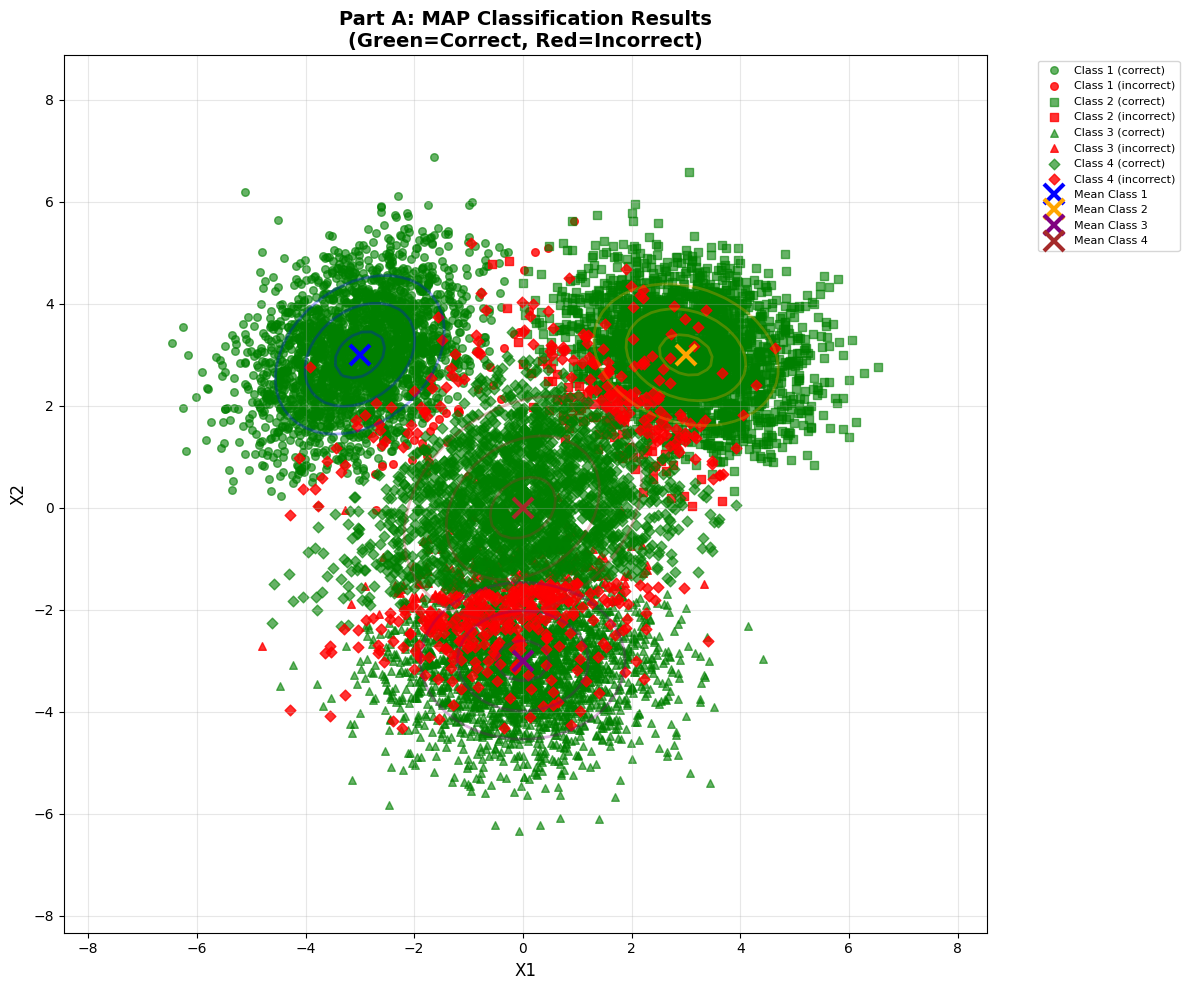

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

markers = ['o', 's', '^', 'D']  
marker_names = ['Circle', 'Square', 'Triangle', 'Diamond']

# Plot 
for label in range(4):
    mask = (true_labels == label)
    correct = (map_predictions[mask] == label)
    incorrect = ~correct
    if np.sum(correct) > 0:
        ax.scatter(X[mask][correct, 0], X[mask][correct, 1], 
                  c='green', marker=markers[label], s=30, alpha=0.6,
                  label=f'Class {label+1} (correct)')
    
    if np.sum(incorrect) > 0:
        ax.scatter(X[mask][incorrect, 0], X[mask][incorrect, 1], 
                  c='red', marker=markers[label], s=30, alpha=0.8,
                  label=f'Class {label+1} (incorrect)')

x_min, x_max = X[:, 0].min() - 2, X[:, 0].max() + 2
y_min, y_max = X[:, 1].min() - 2, X[:, 1].max() + 2
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))
pos = np.dstack((xx, yy))

colors_contour = ['blue', 'orange', 'purple', 'brown']
for i in range(4):
    rv = multivariate_normal(means[i], covs[i])
    ax.contour(xx, yy, rv.pdf(pos), levels=3, 
              colors=colors_contour[i], alpha=0.3, linewidths=2)
    ax.plot(means[i][0], means[i][1], 'x', color=colors_contour[i], 
           markersize=15, markeredgewidth=3, label=f'Mean Class {i+1}')

ax.set_xlabel('X1', fontsize=12)
ax.set_ylabel('X2', fontsize=12)
ax.set_title('Part A: MAP Classification Results\n(Green=Correct, Red=Incorrect)', 
             fontsize=14, fontweight='bold')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


#### Part B - Define Loss Matrix

In [16]:
Lambda = np.array([
    [0,   10,  10, 100],
    [1,   0,   10, 100],
    [1,   1,   0,  100],
    [1,   1,   1,  0]
])

print("\nLoss Matrix Λ (Λ[i,j] = loss for classifying L=j as D=i):")
print("       L=1  L=2  L=3  L=4")
for i in range(4):
    print(f"D={i+1}:", end="")
    for j in range(4):
        print(f"{Lambda[i,j]:4d}", end=" ")
    print()

print("\nNote: Misclassifying Class 4 incurs a loss of 100 units.")



Loss Matrix Λ (Λ[i,j] = loss for classifying L=j as D=i):
       L=1  L=2  L=3  L=4
D=1:   0   10   10  100 
D=2:   1    0   10  100 
D=3:   1    1    0  100 
D=4:   1    1    1    0 

Note: Misclassifying Class 4 incurs a loss of 100 units.


In [17]:
def erm_classify(X, means, covs, priors, Lambda):
    predictions = []
    
    for x in X:
        posteriors = compute_class_posteriors(x, means, covs, priors)
        
        expected_risks = np.zeros(4)
        for i in range(4):
            expected_risks[i] = np.sum(Lambda[i, :] * posteriors)
        
        prediction = np.argmin(expected_risks)
        predictions.append(prediction)
    
    return np.array(predictions)

print("ERM classifier implemented successfully!")

ERM classifier implemented successfully!


#### Apply ERM Classifier and Compute Confusion Matrix

In [18]:
erm_predictions = erm_classify(X, means, covs, class_priors, Lambda)

# Confusion matrix
confusion_matrix_erm = np.zeros((4, 4))
for j in range(4):
    mask = (true_labels == j)
    total_j = np.sum(mask)
    
    if total_j > 0:
        for i in range(4):
            confusion_matrix_erm[i, j] = np.sum(erm_predictions[mask] == i) / total_j

print("\nConfusion Matrix P(D=i|L=j) (rows=decision, columns=true label):")
print("     L=1    L=2    L=3    L=4")
for i in range(4):
    print(f"D={i+1}: ", end="")
    for j in range(4):
        print(f"{confusion_matrix_erm[i,j]:.4f} ", end="")
    print()

total_risk = 0
for i in range(4):
    for j in range(4):
        if i != j:
            mask = (true_labels == j) & (erm_predictions == i)
            total_risk += Lambda[i, j] * np.sum(mask)

min_expected_risk = total_risk / n_samples

print(f"\nMinimum Expected Risk: {min_expected_risk:.4f}")

accuracy_erm = np.sum(erm_predictions == true_labels) / n_samples
print(f"Overall Accuracy: {accuracy_erm:.4f}")

print("\nClassification Decision Distribution:")
for i in range(4):
    count = np.sum(erm_predictions == i)
    print(f"Decided as Class {i+1}: {count} samples ({count/n_samples*100:.2f}%)")



Confusion Matrix P(D=i|L=j) (rows=decision, columns=true label):
     L=1    L=2    L=3    L=4
D=1: 0.7700 0.0000 0.0000 0.0012 
D=2: 0.0000 0.3764 0.0000 0.0032 
D=3: 0.0000 0.0000 0.0931 0.0008 
D=4: 0.2300 0.6236 0.9069 0.9948 

Minimum Expected Risk: 0.5723
Overall Accuracy: 0.5564

Classification Decision Distribution:
Decided as Class 1: 1915 samples (19.15%)
Decided as Class 2: 952 samples (9.52%)
Decided as Class 3: 237 samples (2.37%)
Decided as Class 4: 6896 samples (68.96%)


#### Visualization

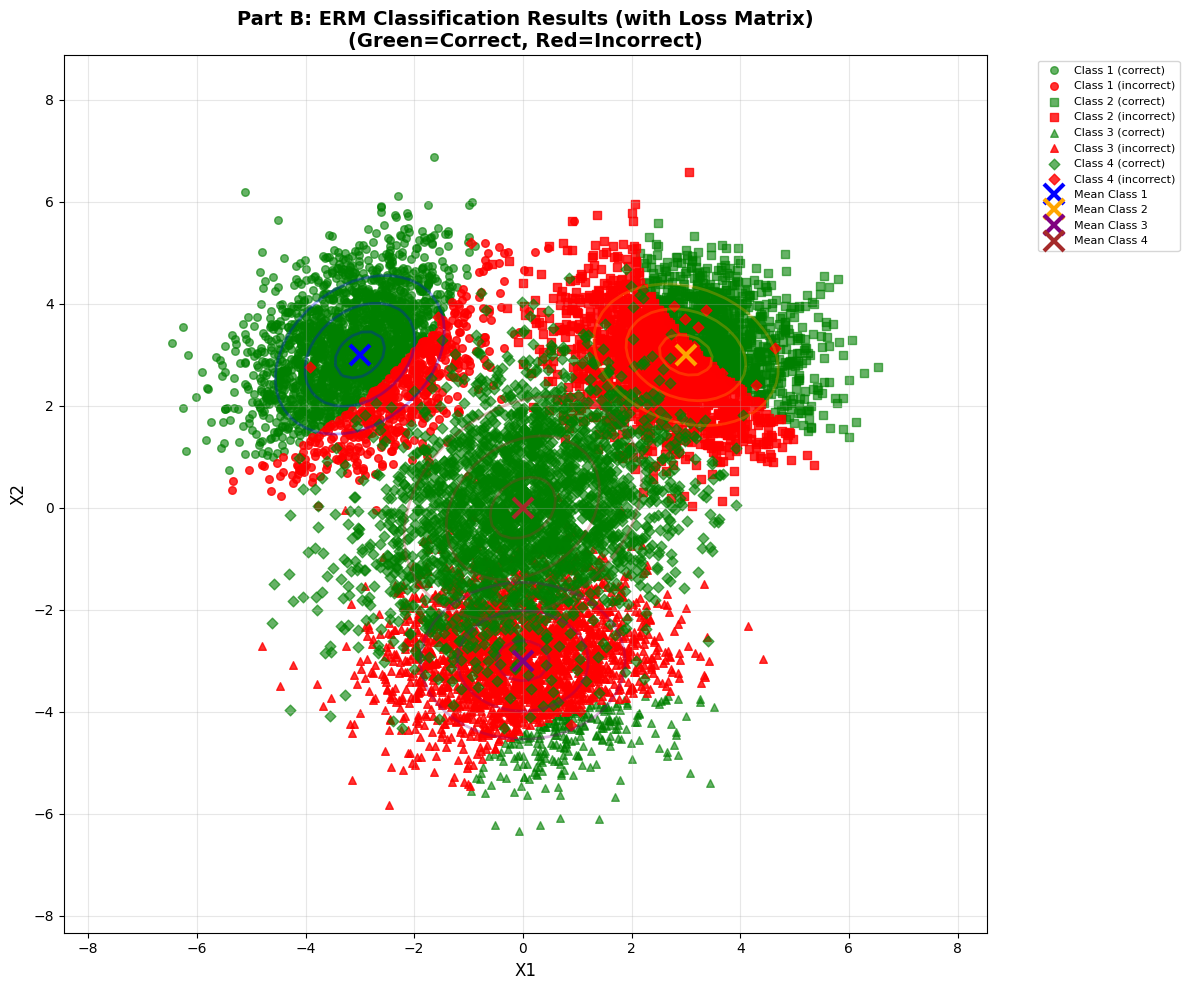

In [19]:

fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# Plot each sample
for label in range(4):
    mask = (true_labels == label)
    correct = (erm_predictions[mask] == label)
    incorrect = ~correct
    
    if np.sum(correct) > 0:
        ax.scatter(X[mask][correct, 0], X[mask][correct, 1], 
                  c='green', marker=markers[label], s=30, alpha=0.6,
                  label=f'Class {label+1} (correct)')
    
    if np.sum(incorrect) > 0:
        ax.scatter(X[mask][incorrect, 0], X[mask][incorrect, 1], 
                  c='red', marker=markers[label], s=30, alpha=0.8,
                  label=f'Class {label+1} (incorrect)')

for i in range(4):
    rv = multivariate_normal(means[i], covs[i])
    ax.contour(xx, yy, rv.pdf(pos), levels=3, 
              colors=colors_contour[i], alpha=0.3, linewidths=2)
    ax.plot(means[i][0], means[i][1], 'x', color=colors_contour[i], 
           markersize=15, markeredgewidth=3, label=f'Mean Class {i+1}')

ax.set_xlabel('X1', fontsize=12)
ax.set_ylabel('X2', fontsize=12)
ax.set_title('Part B: ERM Classification Results (with Loss Matrix)\n(Green=Correct, Red=Incorrect)', 
             fontsize=14, fontweight='bold')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()